In [1]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

https://www.montana.edu/mowkes/research/source-codes/GuideToCFD.pdf

## Navier-Stokes equation (Eulerian form)
The possible movement of $\mathbf{u}$ over $\Delta \mathbf{t}$ written $\frac{\partial \mathbf{u}}{\partial t}$ 
$$ \frac{\partial \mathbf{u}}{\partial t} = -(\mathbf{u} \cdot \nabla)\mathbf{u} + \nu \nabla^2 \mathbf{u} - \frac{1}{\rho}\nabla p $$

Where:
- u: $\mathbf{u}$ the velocities of shape $(N, M, K, 3)$ (3 for the components $u, v, w$) or $(N, M, 2)$ (with components $u, v$) in 2D.
- nu: $\nu$ the viscosity of shape $(1)$, assumed uniform, could be different at each point (temperature variation, non-Newtonian fluids, multiphase flows).
- rho: $\rho$ the density of shape $(1)$. It is a constant in the context of incompressible fluids.
- p: $p$ the pressure of shape $(N, M, K, 1)$ or $(N, M, 1)$ in 2D.

Specifications about the operators:
- dot: $\cdot$ the dot product.
- nabla: $\nabla$ the derivative operator, it produces a gradient when applied on a scalar, it produces a Jacobian matrix when applied on a vector. The velocity field $\mathbf{u}$ is described as follow: $\mathbf{u}(n, m, k, t) \rightarrow (u, v, w)$, with $n, m, k$ the spacial coordinates, $t$ the time (which is discarded when computing because we fix it, we only compute one instant at a time) and $(u, v, w)$ the components of the given velocity. When applying $\nabla$ operator to $\mathbf{u}$ (ie: $\nabla \mathbf{u}$), for each cell, it yields its Jacobian matrix — because each cell is a vector $u, v, w$ — which is a combination of partial derivatives: $$ \begin{pmatrix} \partial_n u & \partial_m u & \partial_k u \\ \partial_n v & \partial_m v & \partial_k v \\ \partial_n w & \partial_m w & \partial_k w \end{pmatrix}$$
- partial: $\partial_n u$ means that for each cell, we take the derivative of $u$ component along the $n$ axis. A derivative at a point is the local rate of change around that point, meaning that, by taking values around the given point, we can compute it as follow: $$\partial_n u_{n,m,k} = \frac{u_{n+1,m,k} - u_{n-1,m,k}}{2 \Delta n}$$. Note that this is only an approximation — it depends from the spacing between each cell, $\Delta n$ — and at edge points, either the approximation is one sided, extra mesh points are added, or the mesh can be cyclic.
- $\nabla^2$ is the Laplacian operator. It is computed component-wise. For each cell, for each component, compute the second derivative along each axis and sum them: $\nabla^2 u = \partial_{nn} u + \partial_{mm} u + \partial_{kk} u$. Using the approximation of the first derivative, the second derivative, $\partial_{nn} u$ can be computed as: $$\partial_{nn} u = \frac{\partial_n u_{i+1} - \partial_n u_{i-1}}{2 \Delta n} = \frac{\frac{u_{i+2} - u_{i}}{2 \Delta n} - \frac{u_{i} - u_{i - 2}}{2 \Delta n}}{2 \Delta n} = \frac{u_{i+2} - 2 u_{i} - u_{i - 2}}{(2 \Delta n)^2}$$
- $(\mathbf{u} \cdot \nabla)\mathbf{u}$ is written this way because $\mathbf{u} \cdot \nabla$ express a directional derivative operator, meaning that, applied to an object, we take its derivative in the direction of $\mathbf{u}$. This mathematical view is helpful to understand the mechanism of the equation. Fluid are usually simulated through two paradigms, Eulerian, or Lagrangian. In Eulerian, we choose stationnary position and see how the velocity evolve in them. In Lagrangian, we follow a particle and observe how its velocity changes in the field. In practice, Eulerian is less compute intensive. At its core, Navier-Stokes is about Lagrangian acceleration, the acceleration of each particle. The movement of a particle is expressed $ \frac{D \mathbf{u}}{D t} =  \nu \nabla^2 \mathbf{u} - \frac{1}{\rho}\nabla p $, the bridge between the Eularian view and the Lagrangian view lie in the formula: $\frac{D \mathbf{u}}{D t} = \frac{\partial \mathbf{u}}{\partial t} + (\mathbf{u} \cdot \nabla)\mathbf{u} $ which can be interpreted as: the acceleration of a particle (because $\mathbf{u}$ is a velocity, and the derivative — $D$ — of velocity is acceleration) can be expressed as the local time rate of change of velocity at a location ($\frac{\partial \mathbf{u}}{\partial t}$ — we do not speak of acceleration anymore because we don't follow a particle, just the rate of change at a given location) plus the velocity change induced by the field ( $(\mathbf{u} \cdot \nabla)$ being its directional derivative, applied to $\mathbf{u}$, it yields its velocity change).
- $(\mathbf{u} \cdot \nabla)\mathbf{u}$ is computed as, for every cell, first $\nabla \mathbf{u}$, compute the Jacobian, then dot product it with the original cell.


<sup><sup>The em dashes are volontary. LLM were used to understand the formula, not to write any of the text.</sup></sup>

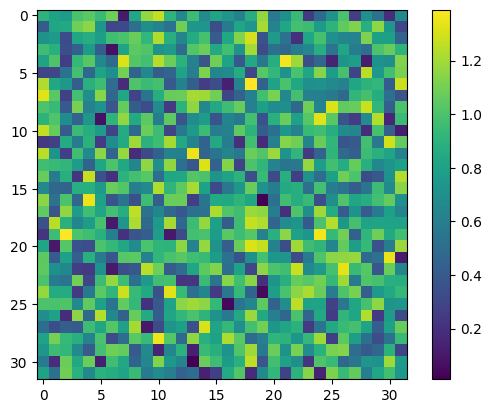

In [2]:
grid_size = (1, 1)
N = 32
M = 32
dim = (N, M, 2)
u = np.random.sample(size=dim)
u_norm = np.linalg.norm(u, axis=2)
plt.imshow(u_norm, label="velocity norm")
plt.colorbar()

In [3]:
nu = 1
rho = 1
p = np.zeros(dim)

### Convection $(\mathbf{u} \cdot \nabla) \mathbf{u}$

In [4]:
u.shape

(32, 32, 2)

In [5]:
convection = np.zeros_like(u)

# Adapt this function if you use a mesh with non uniform spacing
def distance_1d(loc1, loc2):
    return sum(abs(loc1 - loc2) * (1 / N, 1 / M))

def derivative(loc, axis, component):
    prev_pt = np.clip(loc - axis, 0, [N - 1, M - 1])
    next_pt = np.clip(loc + axis, 0, [N - 1, M - 1])
    return (u[*next_pt, component] - u[*prev_pt, component]) / distance_1d(next_pt, prev_pt)
    

for n in range(N):
    for m in range(M):
        grads = np.array([
            [derivative(np.array([n, m]), np.array([1, 0]), 0), derivative(np.array([n, m]), np.array([1, 0]), 1)], 
            [derivative(np.array([n, m]), np.array([0, 1]), 0), derivative(np.array([n, m]), np.array([0, 1]), 1)]])
        convection[n, m] = np.dot(u[n, m], grads)
      

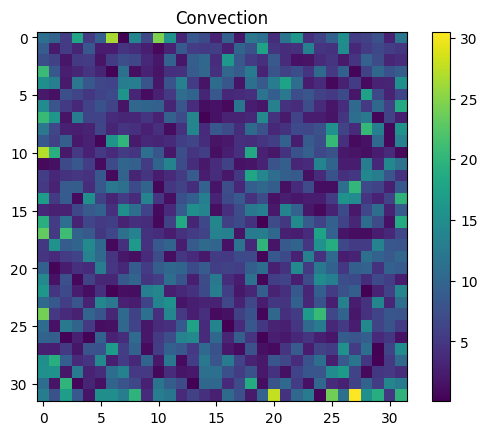

In [6]:
plt.imshow(np.linalg.norm(convection, axis=2))
plt.colorbar()
plt.title("Convection")
plt.show()

### Viscous drag $\nu \nabla^2 \mathbf{u}$

In [7]:
viscous_drag = np.zeros_like(u)

def distance_1d(loc1, loc2):
    return sum(abs(loc1 - loc2) * (1 / N, 1 / M))
    
def derivative_2nd(loc, axis, component):
    prev_pt = np.clip(loc - axis, [0, 0], [N - 1, M - 1])
    next_pt = np.clip(loc + axis, [0, 0], [N - 1, M - 1])
    return (u[*next_pt, component] - (2 * u[*loc, component]) - u[*prev_pt, component]) / distance_1d(next_pt, prev_pt) ** 2

for n in range(N):
    for m in range(M):
        for component in range(2):
            viscous_drag[n, m, component] = nu * (derivative_2nd(np.array([n, m]), np.array([2, 0]), component) + derivative(np.array([n, m]), np.array([0, 2]), component))


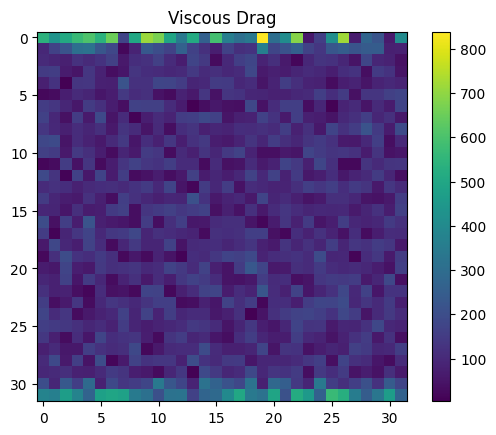

In [8]:
plt.imshow(np.linalg.norm(viscous_drag, axis=2))
plt.colorbar()
plt.title("Viscous Drag")
plt.show()

### Pressure $\frac{1}{\rho}\nabla p$

In [9]:
# (N,M,1) -> (N,M,2)
def compute_pressure(pressure_in):
    pressure_out = np.zeros_like(u)
    
    def distance_1d(loc1, loc2):
        return sum(abs(loc1 - loc2) * (1 / N, 1 / M))
    
    def derivative(loc, axis):
        prev_pt = np.clip(loc - axis, 0, [N - 1, M - 1])
        next_pt = np.clip(loc + axis, 0, [N - 1, M - 1])
        return (pressure_in[*next_pt, 0] - pressure_in[*prev_pt, 0]) / distance_1d(next_pt, prev_pt)
        
    for n in range(N):
        for m in range(M):
            pressure_out[n, m, 0] = derivative(np.array([n, m]), np.array([1, 0]))
            pressure_out[n, m, 1] = derivative(np.array([n, m]), np.array([0, 1]))
    
    return (1 / rho) * pressure_out

pressure = compute_pressure(p)

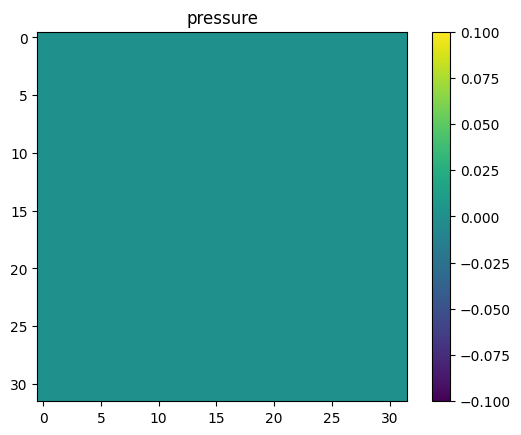

In [10]:
plt.imshow(np.linalg.norm(pressure, axis=2))
plt.colorbar()
plt.title("pressure")
plt.show()

### $\frac{\partial \mathbf{u}}{\partial t}$

In [11]:
velocity_change = -convection + viscous_drag

In [12]:
dt = 0.01

# Compute intermediate stage without the pressure 
u_pred = u + velocity_change * dt

Continuity equation: $$ \nabla \cdot \mathbf{u} = 0$$

Where:
- $\nabla \cdot$ is the divergence operator and is computed the following way: $\nabla \cdot \mathbf{u} = \partial_n u + \partial_m v + \partial_k w$. Note that it takes a vector and output a scalar.

$\nabla$ operator recap:
- $\nabla \cdot$ the divergence operator, vector to scalar
- $\nabla$ the gradient, scalar to vector, vector to matrix
- $\nabla^2$ the Laplacian operator, vector to vector, can be seen as $\nabla \cdot \nabla$ (vector to scalar to vector)


Now is time to solve the pressure to keep the continuity equation valid.

$$ \nabla^2 p^{s+1} = \frac{\rho}{\Delta t} \nabla \cdot u^* $$
The above equation express the pressure $p$ at a step $s+1$, with the velocity change $u^*$ from step $s$.
A better explanation than what I could provide awaits at the page 4 of this [document](https://www.montana.edu/mowkes/research/source-codes/GuideToCFD.pdf).

There is no direct way of computing an inverse of the $\nabla^2$ operator. We will use an iterative method.
Poisson equation is reframed as: $$ L p^{s+1} = R $$


$$\nabla^2 p^{s+1} = \frac{\partial^2p^{s+1}}{\partial u^{2}} + \frac{\partial^2p^{s+1}}{\partial v^{2}}$$

Where:
$$\frac{\partial^2p^{s+1}}{\partial u^{2}} = \frac{\partial^2p^{s+1}}{\partial n^{2}}$$
Or at least I think it is since $\mathbf{u}$ is aligned with $n$ in my model, hence:
$$\frac{\partial^2p^{s+1}}{\partial u^{2}} = \partial_{nn}p^{s+1} = \frac{p_{n+2,m} - 2 p_{n,m} - p_{n-2,m}}{(2 \Delta n)^2}$$
Therefore
$$\nabla^2 p^{s+1} = \frac{p_{n+2,m} - 2 p_{n,m} - p_{n-2,m}}{(2 \Delta n)^2} + \frac{p_{n,m+2} - 2 p_{n,m} - p_{n,m-2}}{(2 \Delta m)^2}$$

$$\frac{(p_{n+2,m} - 2 p_{n,m} - p_{n-2,m}) * (2 \Delta m)^2}{(2 \Delta n)^2 * (2 \Delta m)^2} + \frac{(p_{n,m+2} - 2 p_{n,m} - p_{n,m-2}) * (2 \Delta n)^2}{(2 \Delta n)^2 * (2 \Delta m)^2}$$

$$\frac{(p_{n+2,m} - p_{n-2,m}) * (2 \Delta m)^2 + (p_{n,m+2} - p_{n,m-2}) * (2 \Delta n)^2 }{(2 \Delta n)^2 * (2 \Delta m)^2} + \frac{-2 p_{n,m} * (2 \Delta n)^2 - 2 p_{n,m} * (2 \Delta m)^2}{(2 \Delta n)^2 * (2 \Delta m)^2} = R_{n,m}$$

$$(p_{n+2,m} - p_{n-2,m}) * (2 \Delta m)^2 + (p_{n,m+2} - p_{n,m-2}) * (2 \Delta n)^2 -2 p_{n,m} * (2 \Delta n)^2 - 2 p_{n,m} * (2 \Delta m)^2 = R_{n,m} * (2 \Delta n)^2 * (2 \Delta m)^2$$

$$p_{n,m} = \frac{(p_{n+2,m} - p_{n-2,m}) * 4\Delta m^2 + (p_{n,m+2} - p_{n,m-2}) * 4 \Delta n^2 - R_{n,m} * 4 \Delta n^2 * 4 \Delta m^2}{8(\Delta n^2 + \Delta m^2)}$$

Note that if $\Delta n = \Delta m$, this equation is far simpler:
$$p_{n,m} = \frac{(p_{n+2,m} - p_{n-2,m} + p_{n,m+2} - p_{n,m-2}) - R_{n,m} * 4 \Delta n^2}{4}$$

In [25]:

# Solve pressure from frame 1 to ensure continuity
p2 = np.zeros_like(p)

def fetch(source, mock):
    def fetch_intern(n, m):
        if n < 0 or n >= N:
            return mock
        if m < 0 or m >= M:
            return mock
        return source[n, m]
    return fetch_intern

dn = 1 / N
dm = 1 / M

fetch_p = fetch(p, 0)
fetch_u = fetch(u, 0)

for n in range(N):
    for m in range(M):
        rnm = rho / dt * ((fetch_u(n + 1, m) - fetch_u(n - 1, m)) / (2 * dn) + (fetch_u(n, m + 1) - fetch_u(n, m - 1)) / (2 * dm) )
        x = (fetch_p(n + 2, m) - fetch_p(n - 2, m)) * 4 * dm ** 2 + (fetch_p(n, m + 2) - fetch_p(n, m - 2)) * 4 * dn ** 2
        x -= rnm * 16 * dn ** 2 * dm ** 2
        x /= 8 * (dn ** 2 + dm ** 2)
        p2[n, m] = x

# Compute the estimated pressure for frame 2
pressure_2 = compute_pressure(p2)

In [26]:

u2 = u_pred - pressure_2

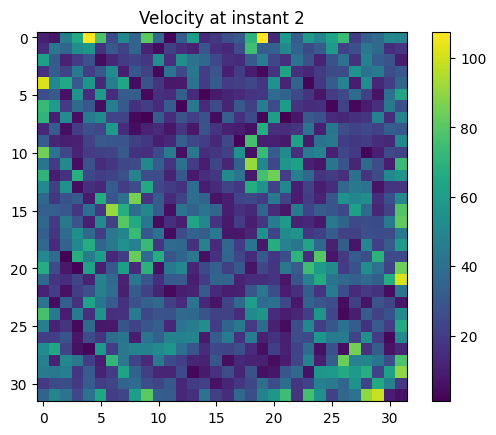

In [27]:
plt.imshow(np.linalg.norm(u2, axis=2))
plt.colorbar()
plt.title("Velocity at instant 2")
plt.show()

### Beautiful!!

I am almost certain that the above code & thought process is full of errors, but I am still very happy with this first result. We can see the emergence of patterns even if this is only the first iteration.

The next steps are:
- Make it chainable up to any number of iteration
- Challenge accuracy & performance:
  - To improve performance, first benchmark then try using numpy op, pytorch unfold, c++ bindings, ...
  - to improve accuracy, compare against a reference simu? But what if it is physically correct but formulas ratio or randomness is slighlty different? Maybe by evaluating in a statistical manner to determine if the simulation is realistic could do! Check continuity, velocity, entropy.
- I know that I paid no attention to boundary condition, this could be a first fix.
- For 2nd order derivative, I simply derived the formula from the 1st order, resulting in a larger stencil size. I want to see how the result would differ by only check with the first neighbors.
- Check when $N \not= M$ and $\Delta n \not= \Delta m$
- Go to 3D maybe?

Try validating with [lid driven cavity problem](https://www.cfd-online.com/Wiki/Lid-driven_cavity_problem)